### What is the most optimal skill to learn for Machine Learning Engineers?

#### Methodology

1. Continue from last notebook to find percent of postings with skill
2. Visualize median salary vs percent skill demand
3. (Optional) Determine if certain technologies are more prevalent

## Import Libraries

In [36]:
# let's inistall the libraries first 
!pip install -q datasets
!pip install -q adjustText
!pip install -q requests


In [37]:
# WE can now import all of the necessary libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt 
import requests # to get the continents for the jobs

## Load Datasets

In [38]:
# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

## Data Cleanup

In [39]:
# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [40]:
# country for analysis and per continent analysis as well
df_country = df['job_country'].value_counts().to_frame(name='count')
df_country.reset_index(inplace=True)
df_country.rename(columns={'index':'Country'},inplace=True)
df_country.drop(columns='count',inplace=True)
df_country.head()

,Country
0,United States
1,India
2,United Kingdom
3,France
4,Germany


In [41]:
def get_continent(country):
    try:
        # Use the RestCountries API to fetch country information
        response = requests.get(f'https://restcountries.com/v3.1/name/{country}')
        data = response.json()
        return data[0]['continents'][0]  
    except Exception as e:
        return 'Unknown'


# Apply the function to the job_country column
df_country['continent'] = df_country['Country'].apply(get_continent)

In [42]:

fix_continents = {
    "United States": "North America",
    "Australia": "Oceania",
    "New Zealand": "Oceania",
    "Guam": "Oceania",
    "U.S. Virgin Islands": "North America",
    "Macedonia (FYROM)": "Europe",
    "Congo, Democratic Republic of the": "Africa",
    "Fiji": "Oceania",
    "Papua New Guinea": "Oceania",
    "Northern Mariana Islands": "Oceania"
}

# Update the continent column based on the mapping
df_country['continent'] = df_country['Country'].map(fix_continents).fillna(df_country['continent'])

In [43]:
df_merged = df.merge(df_country, how='left',left_on='job_country',right_on='Country')
df_merged.head(3)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills,Country,continent
0,Senior Data Engineer,Senior Clinical Data Engineer / Principal Clin...,"Watertown, CT",via Work Nearby,Full-time,False,"Texas, United States",2023-06-16 13:44:15,False,False,United States,None,NaN,NaN,Boehringer Ingelheim,None,None,United States,North America
1,Data Analyst,Data Analyst,"Guadalajara, Jalisco, Mexico",via BeBee México,Full-time,False,Mexico,2023-01-14 13:18:07,False,False,Mexico,None,NaN,NaN,Hewlett Packard Enterprise,"[r, python, sql, nosql, power bi, tableau]","{'analyst_tools': ['power bi', 'tableau'], 'pr...",Mexico,North America
2,Data Engineer,"Data Engineer/Scientist/Analyst, Mid or Senior...","Berlin, Germany",via LinkedIn,Full-time,False,Germany,2023-10-10 13:14:55,False,False,Germany,None,NaN,NaN,ALPHA Augmented Services,"[python, sql, c#, azure, airflow, dax, docker,...","{'analyst_tools': ['dax'], 'cloud': ['azure'],...",Germany,Europe


Filters the original dataset to only get rows where the job title is 'Machine Learning Engineer' or 'Data Scientist' and also another one for the continent in 'Africa', to create a new DataFrame `df_ml` and `df_ml_africa`. Drop NaN values from the 'salary_year_avg' column. Then it uses the `explode` method on the `job_skills` column to create a new row in a new DataFrame (`df_ml_exploded`) for each skill associated with a job. Finally, it displays the first 5 entries of the `salary_year_avg` and `job_skills` columns.

In [44]:
df_ml = df_merged[df_merged['job_title_short'].isin(['Data Scientist','Machine Learning Engineer'])].copy()

# Drop NaN values from the 'salary_year_avg' column for accurate visualization
df_ml = df_ml.dropna(subset=['salary_year_avg'])
df_ml_exploded = df_ml.explode('job_skills')


#Africa df
df_ml_africa = df_merged[(df_merged['job_title_short'].isin(['Data Scientist','Machine Learning Engineer'])) & (df_merged['continent'] == 'Africa')].copy()
df_ml_africa = df_ml_africa.dropna(subset=['salary_year_avg'])
df_ml_africa_exploded = df_ml_africa.explode('job_skills')


df_ml_exploded[['salary_year_avg', 'job_skills','continent']].head(5)

,salary_year_avg,job_skills,continent
28,109500.0,gdpr,North America
28,109500.0,excel,North America
100,228222.0,sql,North America
100,228222.0,r,North America
100,228222.0,python,North America


In [45]:
df_ml_africa_exploded[['salary_year_avg', 'job_skills','continent']].head(5)

,salary_year_avg,job_skills,continent
5862,325000.0,python,Africa
5862,325000.0,java,Africa
5862,325000.0,sql,Africa
5862,325000.0,aws,Africa
5862,325000.0,gcp,Africa


#### Calculate Percent of Job Postings that Have Skills

Group the data by job skills and calculate the count and median salary for each skill, sorting the results in descending order by count. It then renames the columns. Calculates the percentage that each skill count represents out of the total number of Machine Learning jobs. Finally, filter out any skills that don't have any jobs associated with them

In [46]:
df_ml_skills = df_ml_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)
df_ml_skills = df_ml_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'})
ml_job_count = len(df_ml)  # Find count of ML jobs
df_ml_skills['skill_percent'] = df_ml_skills['skill_count'] / ml_job_count * 100

df_ml_skills = df_ml_skills[df_ml_skills['skill_count'] > 0]

#Africa
df_ml_africa_skills = df_ml_africa_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)
df_ml_africa_skills = df_ml_africa_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'})
ml_job_africa_count = len(df_ml_africa)  # Find count of ML jobs
df_ml_africa_skills['skill_percent'] = df_ml_africa_skills['skill_count'] / ml_job_africa_count * 100

df_ml_africa_skills = df_ml_africa_skills[df_ml_africa_skills['skill_count'] > 0]

df_ml_skills

,skill_count,median_salary,skill_percent
job_skills,,,
python,4702,130000.0,72.360726
sql,3260,132500.0,50.169283
r,2541,125000.0,39.104340
tableau,1291,125000.0,19.867652
sas,1242,118080.0,19.113573
...,...,...,...
monday.com,1,79019.0,0.015389
npm,1,147500.0,0.015389
qt,1,110000.0,0.015389


In [47]:
df_ml_africa_skills.head(10)

,skill_count,median_salary,skill_percent
job_skills,,,
python,464,130000.0000,74.121406
sql,314,132124.9375,50.159744
r,243,119550.0000,38.817891
sas,142,117500.0000,22.683706
tableau,131,127500.0000,20.926518
aws,124,138500.0000,19.808307
spark,107,142500.0000,17.092652
tensorflow,78,140755.5000,12.460064
azure,78,131000.0000,12.460064


### Median Salary vs Percent Skill Demand

Filters for ML skills that exceed a certain percentage 
    
>i.e skill_limit

In [48]:
skill_limit = 5
df_ml_skills_high_demand = df_ml_skills[df_ml_skills['skill_percent']>skill_limit]
df_ml_africa_skills_high_demand = df_ml_africa_skills[df_ml_africa_skills['skill_percent']>skill_limit]


Create a scatter plot to visualize the relationship between the percentage of Data Scientist / Machine Learning jobs that require specific skills and the median salary for those skills.

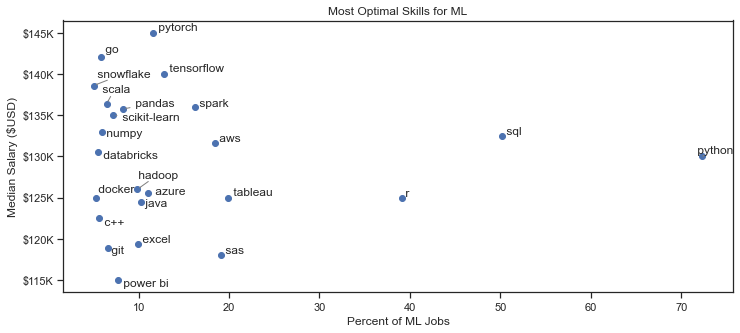

In [49]:
from adjustText import adjust_text

plt.figure(figsize=(12, 5))
plt.scatter(df_ml_skills_high_demand['skill_percent'], df_ml_skills_high_demand['median_salary'])
plt.xlabel('Percent of ML Jobs')
plt.ylabel('Median Salary ($USD)')
plt.title('Most Optimal Skills for ML')

# Get current axes, set limits, and format axes
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))  # Example formatting y-axis

# Add labels to points and collect them in a list
texts = []
for i, txt in enumerate(df_ml_skills_high_demand.index):
    texts.append(plt.text(df_ml_skills_high_demand['skill_percent'].iloc[i], df_ml_skills_high_demand['median_salary'].iloc[i], " " + txt))

# Adjust text to avoid overlap and add arrows
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

plt.show()

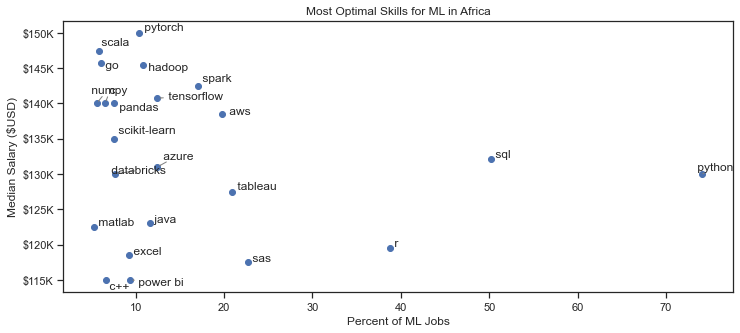

In [50]:
plt.figure(figsize=(12, 5))
plt.scatter(df_ml_africa_skills_high_demand['skill_percent'], df_ml_africa_skills_high_demand['median_salary'])
plt.xlabel('Percent of ML Jobs')
plt.ylabel('Median Salary ($USD)')
plt.title('Most Optimal Skills for ML in Africa')

# Get current axes, set limits, and format axes
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))  # Example formatting y-axis

# Add labels to points and collect them in a list
texts = []
for i, txt in enumerate(df_ml_africa_skills_high_demand.index):
    texts.append(plt.text(df_ml_africa_skills_high_demand['skill_percent'].iloc[i], df_ml_africa_skills_high_demand['median_salary'].iloc[i], " " + txt))

# Adjust text to avoid overlap and add arrows
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

plt.show()

## Coloring by Technology

> Let's take our visualizations one step further by coloring each skill with the technology group they belong to.

In order to do so we first Remove duplicate entries and any row with missing values. Then, it combines all dictionary entries into a single dictionary, summing values for keys that repeat across entries. To ensure each key's values are unique, it converts the values to a set and then back to a list. The final result is a dictionary where each key represents a skill and each value is a list of unique attributes associated with that skill.


In [51]:
df_merged['job_type_skills']

0                                                      None
1         {'analyst_tools': ['power bi', 'tableau'], 'pr...
2         {'analyst_tools': ['dax'], 'cloud': ['azure'],...
3         {'cloud': ['aws'], 'libraries': ['tensorflow',...
4         {'cloud': ['oracle', 'aws'], 'other': ['ansibl...
                                ...                        
785736    {'os': ['linux', 'unix'], 'other': ['kubernete...
785737    {'analyst_tools': ['sas', 'excel'], 'programmi...
785738           {'analyst_tools': ['powerpoint', 'excel']}
785739    {'cloud': ['aws', 'snowflake', 'azure', 'redsh...
785740                {'cloud': ['aws'], 'other': ['flow']}
Name: job_type_skills, Length: 785741, dtype: object

In [52]:
df_technology = df_merged['job_type_skills'].copy()
# Let's now remove duplilcates and also NaN values
df_technology = df_technology.drop_duplicates()
df_technology = df_technology.dropna()


technology_dict = {}

for row in df_technology:
    row_dict = ast.literal_eval(row) #convert the columns dtype from string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:
            technology_dict[key] += value
        else:
            technology_dict[key] = value 
#remove duplicates by converting the values to set then to list back again
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

#let's take a look at the final dict
technology_dict

{'analyst_tools': ['visio',
  'esquisse',
  'sas',
  'dax',
  'outlook',
  'spreadsheet',
  'datarobot',
  'spss',
  'ssis',
  'alteryx',
  'tableau',
  'powerpoint',
  'nuix',
  'sap',
  'powerbi',
  'sheets',
  'qlik',
  'power bi',
  'word',
  'sharepoint',
  'ssrs',
  'ms access',
  'splunk',
  'excel',
  'microstrategy',
  'looker',
  'msaccess',
  'cognos'],
 'programming': ['apl',
  'c#',
  'cobol',
  'mongo',
  'sas',
  'elixir',
  'erlang',
  'matlab',
  'f#',
  'html',
  'go',
  'vba',
  'javascript',
  'mongodb',
  'vb.net',
  'clojure',
  'julia',
  'dart',
  'lisp',
  'no-sql',
  'visualbasic',
  'shell',
  'kotlin',
  'bash',
  'typescript',
  'r',
  'pascal',
  'nosql',
  'objective-c',
  'powershell',
  'visual basic',
  'assembly',
  'java',
  'crystal',
  'fortran',
  'php',
  'delphi',
  'solidity',
  'ocaml',
  'c++',
  'c',
  't-sql',
  'swift',
  'groovy',
  'css',
  'scala',
  'sql',
  'perl',
  'sass',
  'haskell',
  'ruby',
  'golang',
  'rust',
  'lua',
  'pyt

In [53]:
len(technology_dict)

my_dict = technology_dict.copy()

# Initialize lists to store lengths and types
keys_info = []
values_info = []

# Iterate through the dictionary
for key, value in my_dict.items():
    keys_info.append((key, len(key), type(key)))
    values_info.append((value, len(str(value)), type(value)))

# Print results
print("Keys Information:")
for info in keys_info:
    print(f"Key: '{info[0]}', Length: {info[1]}, Type: {info[2]}")


Keys Information:
Key: 'analyst_tools', Length: 13, Type: <class 'str'>
Key: 'programming', Length: 11, Type: <class 'str'>
Key: 'cloud', Length: 5, Type: <class 'str'>
Key: 'libraries', Length: 9, Type: <class 'str'>
Key: 'other', Length: 5, Type: <class 'str'>
Key: 'databases', Length: 9, Type: <class 'str'>
Key: 'os', Length: 2, Type: <class 'str'>
Key: 'async', Length: 5, Type: <class 'str'>
Key: 'webframeworks', Length: 13, Type: <class 'str'>
Key: 'sync', Length: 4, Type: <class 'str'>


This code converts a dictionary into a pandas DataFrame, then explodes the 'skills' column, creating multiple rows for each 'technology' entry if it contains multiple skills.

In [54]:
# turn dictionary into dataframe
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])
df_technology = df_technology.explode('skills')
df_technology

,technology,skills
0,analyst_tools,visio
0,analyst_tools,esquisse
0,analyst_tools,sas
0,analyst_tools,dax
0,analyst_tools,outlook
...,...,...
9,sync,zoom
9,sync,ringcentral
9,sync,slack
9,sync,microsoft teams


Merges two DataFrames, df_ml_skills and df_technology, based on the columns 'job_skills' and 'skills' respectively, creating a new DataFrame df_ml_skills_tech.

In [55]:
# merge df_ml_skills and df_technology
df_ml_skills_tech = df_ml_skills.merge(df_technology, left_on='job_skills', right_on='skills')

df_ml_skills_tech.head()

,skill_count,median_salary,skill_percent,technology,skills
0,4702,130000.0,72.360726,programming,python
1,3260,132500.0,50.169283,programming,sql
2,2541,125000.0,39.104340,programming,r
3,1291,125000.0,19.867652,analyst_tools,tableau
4,1242,118080.0,19.113573,analyst_tools,sas


Filters df_ml_skills_tech to select rows where the 'percent' column exceeds a specified threshold, storing the result in df_ml_skills_tech_high_demand.

In [56]:
df_ml_skills_tech_high_demand = df_ml_skills_tech[df_ml_skills_tech['skill_percent'] > skill_limit]
df_ml_skills_tech_high_demand

,skill_count,median_salary,skill_percent,technology,skills
0,4702,130000.000000,72.360726,programming,python
1,3260,132500.000000,50.169283,programming,sql
2,2541,125000.000000,39.104340,programming,r
3,1291,125000.000000,19.867652,analyst_tools,tableau
4,1242,118080.000000,19.113573,analyst_tools,sas
5,1242,118080.000000,19.113573,programming,sas
6,1196,131655.000000,18.405663,cloud,aws
7,1058,135959.500000,16.281933,libraries,spark
8,834,140000.000000,12.834718,libraries,tensorflow
9,752,145000.000000,11.572792,libraries,pytorch


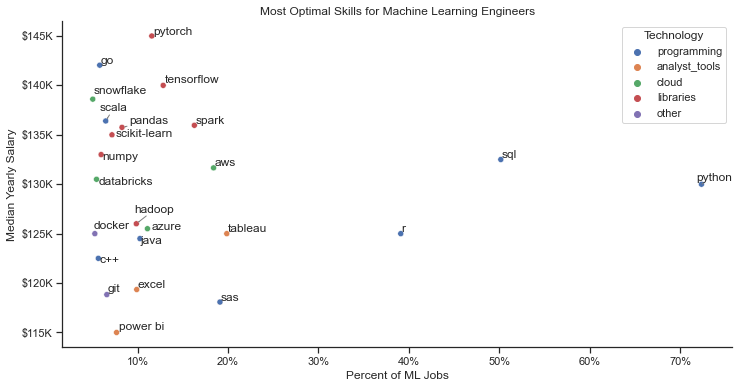

In [57]:
# Scatterplot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_ml_skills_tech_high_demand,
    x='skill_percent',
    y='median_salary',
    hue='technology'
)

sns.despine()
sns.set_theme(style='ticks')

# Prepare texts for adjustment
texts = []  # Initialize an empty list for text objects
for i, skill_name in enumerate(df_ml_skills_high_demand.index):
    x = df_ml_skills_high_demand['skill_percent'].iloc[i]
    y = df_ml_skills_high_demand['median_salary'].iloc[i]
    texts.append(plt.text(x, y, skill_name))  

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# Set axis labels, title, and legend
plt.xlabel('Percent of ML Jobs')
plt.ylabel('Median Yearly Salary')
plt.title('Most Optimal Skills for Machine Learning Engineers')
plt.legend(title='Technology')

from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))    

plt.show()


In [58]:
df_ml_skills_high_demand.index

Index(['python', 'sql', 'r', 'tableau', 'sas', 'aws', 'spark', 'tensorflow',
       'pytorch', 'azure', 'java', 'excel', 'hadoop', 'pandas', 'power bi',
       'scikit-learn', 'git', 'scala', 'numpy', 'go', 'c++', 'databricks',
       'docker', 'snowflake'],
      dtype='object', name='job_skills')